In [2]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import pandas as pd
from scipy.spatial import KDTree
import json

from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [3]:
%matplotlib inline

# Going to try debugging this one now

In [ ]:

   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }
#empty data frame to append values of flux to
rows=[]

In [ ]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
wcs = cutout.wcs

#####   constants in every image:

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask



#####  End of constants










##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = image_data * non_overlapping_mask
                target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
            #filter only valid sources to conduct the overlapping photometry again. 
        # so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
        #valid_sources = display_data[display_data['Flag'] == 'Valid']

        for i, valid_row in display_data[display_data['Flag'] == 'Valid'].iterrows():
            x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
            target_aperture = CircularAperture((x, y), r)
            target_photo_table = aperture_photometry(image_data, target_aperture)
            target_counts = target_photo_table['aperture_sum'][0]
            
            if target_counts <= 0:
                target_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
                target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
                target_area = target_aperture.area

            non_overlapping_counts = target_counts

            for j, valid_row2 in display_data[display_data['Flag'] == 'Valid'].iterrows():
                if i != j:
                    x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
                    distance = dist((x, y), (x2, y2))
                    if distance < r + r2:
                        overlap_percent = (r + r2 - distance) / (r + r2)
                        if overlap_percent > .01: # i think i will have to fiddle around with this
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                            non_overlapping_counts -= overlap_counts
                            

            if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
                net_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
                net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

            # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
            display_data.loc[i, 'Net Flux (Jy)'] = net_flux
            display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'

     
        
     ## Trying to plot the images now
     #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        #plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    





#rows.append({'band_id': {band_labels[band_id]},
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures

#for row in display_data.itertuples():
    #if row.Flag == 'Valid':
       # target_aperture = CircularAperture((row.X, row.Y), row.Radius)
       # annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
       # target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
       # annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)





# Just one band

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
#for i in range(len(im_table)):
   # print(im_table[i])

In [ ]:
for i in range(len(im_table)):
    if im_table[i]['sia_bp_id']:

        print(im_table[i].getdataurl())

In [ ]:
data_url = im_table[0].getdataurl()
#Download the image and open it in Astropy
fname = download_file(data_url, cache=True)
image1= fits.open(fname)
image_data= image1[0].data
print(data_url)

In [ ]:
#grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
sources_7793


In [ ]:
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values


In [ ]:
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
print(image_data.shape)
print(cutout.data.shape)
# THIS IS WHERE THE DISCREPANCY IS HAPPENING.
# When i make the image shape the same, the positions of the sources are almost identical to the 
# image downloaded code.
wcs = cutout.wcs
cutout_data = cutout.data

In [ ]:
#define the KDTree
# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 10

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)
# a problem could be with grouped postions maybe?
# here is where the code between downloading the image and using the URL differs!
#  the position of sources is slightly altered for some reason.

In [ ]:

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band
cutout_data.shape
grouped_positions


In [ ]:

# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target objects in the little aperture circle define their target apertures
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = cutout_data * non_overlapping_mask
        target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the target
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area

        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
        #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    

#append the rows to the empty dataframe    
display_data = pd.DataFrame(rows)
display_data

valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(cutout_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'



#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()

display_data.loc[display_data['Flag']== 'Valid']



## dont think i need this 

In [ ]:


#filter only valid sources to conduct the overlapping photometry again. 
# so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(cutout_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'


#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()

display_data.loc[display_data['Flag']== 'Valid']
#display_data

# the new code for when i want to apply it to all wavelengths :

remember to include the code for different flux conversions for each band!!

In [4]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }
#empty data frame to append values of flux to
rows=[]

<SkyCoord (ICRS): (ra, dec) in deg
    (359.457, -32.592)>
('W4 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 0.0, -33.317778, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([  0.      , -33.317778]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-cov-3.fits.gz', '0000m334_ac51')
('W1 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_62476/875853337.py:23: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


In [5]:
#DELETE THIS WHEN YOU HAVE PUT IN THE CONVERSION Code
M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

## dont use this

In [ ]:
cutout_alldata = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
       # print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data # maybe this needs to be assigned as a dictionary for each of them.
        cutout_alldata.append({ 'Band': {band_labels[band_id]}, 'CutoutData' : cutout_data, 'WCS': wcs})
cutout_alldata = pd.DataFrame(cutout_alldata)
cutout_alldata['ROI'] = np.nan
display(cutout_alldata)

#cutout_alldata = pd.DataFrame(columns=['Band', 'CutoutData', 'WCS'])  # Initialize with columns
#for i in [0, 3, 2, 1]:  # Reverse order index
  #  band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
   # if band_id in band_labels:
   #    # print(f'Band {band_labels[band_id]}: ')
    #    data_url = im_table[i].getdataurl()
   #     #Download the image and open it in Astropy
   #     fname = download_file(data_url, cache=True)
   #     image1= fits.open(fname)
    #    image_data= image1[0].data
        #print(data)
        
     #   wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
     #   cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
      #  wcs = cutout.wcs
      #  cutout_data = cutout.data # maybe this needs to be assigned as a dictionary for each of them.
      #  cutout_alldata.loc[len(cutout_alldata)] = [band_id, cutout_data, wcs]
        #cutout_alldata._append({ 'Band': {band_labels[band_id]}, 'CutoutData' : cutout_data, 'WCS': wcs}, ignore_index= True)

display(cutout_alldata)

for idx, row in cutout_alldata.iterrows():
    wcs = row.WCS
    positions = wcs.world_to_pixel_values(ra, dec)
    positions = np.array(list(zip(positions[0], positions[1])))

    #define the distance threshold for the KDTree grouping (in pixels)
    distance_threshold = 11

    #build the KDTree for efficient grouping
    tree = KDTree(positions)

    #query the KDTree to find points within the defined radius of dist threshold and group them together
    groups = tree.query_ball_tree(tree, r=distance_threshold)
    print(groups)
    # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
    unique_groups = []
    seen = set()
    for group in groups:
        group = tuple(sorted(group))
        if group not in seen:
            seen.add(group)
            unique_groups.append(group)
    print(unique_groups)
    # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
    #represents the consolidated postion of potentially multiple detections of one source.
    grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
    print(grouped_positions)

    #define the Region(s) Of Interest (center x, center y, radius)
    ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
    #empty data frame to append values of flux to
    roi_str = json.dumps(ROI) # to revert back : roi_list = json.loads(cutout_alldata.at[idx, 'ROI'])
    cutout_alldata.at[idx, 'ROI'] = roi_str
display(cutout_alldata)

for idx, row in cutout_alldata.iterrows(): 
    roi_list = json.loads(row['ROI'])
    band_id = row['Band']
    cutout_data = row['CutoutData']
    #now inputting the aperture photometry part
    # check for overlap and perform aperture photometry
    for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(roi_list):
        overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
        non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

        for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(roi_list): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
            if i != j: # ensures that a source is not compared to itself! wow
                distance = dist((x, y) , (x2, y2)) 
                if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                    overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                    if overlap_percent > .5:
                        overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                        break
                    else: 
                        overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                        non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                        # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                        # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                    
        if overlap:
            #flag the sources that overlap
            rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
        else: #perform all the aperture photometry stuff
            # For the Target objects in the little aperture circle define their target apertures
            target_aperture = CircularAperture((x,y),r,)
        
            #perform aperture photometry on target
            # also now apply the masked data
            masked_data = cutout_data * non_overlapping_mask
            target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
            target_counts = target_photo_table['aperture_sum'][0]

            if target_counts<= 0: # 
                target_flux # avoid taking the log of zero or negative value
            else:
                    #counts to flux
                Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                #calculate area of annulus
            target_area = target_aperture.area



            # For the Background Annuli of outside of the Target
            #define the background annulus for the target
            annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

            #perform aperture photometry on annuli
            annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
            annulus_counts = annulus_photo_table['aperture_sum'][0]
        
            if annulus_counts <= 0:
                annulus_flux = 0  # Avoid taking log of zero or negative value
            else:
                #counts to flux
                Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

            #calculate area of annulus
            annulus_area = annulus_aperture.area

            # do the calculations for including a Background aperture
        
            #Calculating the net flux:
            #calculate the mean background per pixel
            bg_perpixel = annulus_flux/annulus_area

            #calculate the total background in the target aperture
            tot_bg = bg_perpixel * target_area

            #Subtract background from the target flux
            net_flx = target_flux - tot_bg
        
            #   Append the result as a dictionary to the list named 'rows'
            rows.append({ 'band_id': band_id,'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                    'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                    'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                        'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                        'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
        #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
    
display_data = pd.DataFrame(rows)
display(display_data)

fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()


## maybe

In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        print(data_url)
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cutting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data

        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 10

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        #empty data frame to append values of flux to


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
    
     ## Trying to plot the images now
        

display_data = pd.DataFrame(rows)
display_data

for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    








display(display_data)
#display(display_data.loc[display_data['Flag']== 'Valid'])
#pd.set_option("display.max_rows", None)



# best version of the code so far
only problem is that it only does the aperture phot on W1. trying to fix that now in the "dont use this" section

Band W4: 
[[148.49783 148.49527 148.4903  ... 148.5779  148.57916 148.57774]
 [148.49313 148.49083 148.4858  ... 148.58298 148.58423 148.5824 ]
 [148.49055 148.48866 148.48354 ... 148.58861 148.59023 148.58784]
 ...
 [148.37071 148.37186 148.36841 ... 148.57794 148.56554 148.55298]
 [148.37878 148.37746 148.37076 ... 148.57831 148.56403 148.55008]
 [148.38974 148.38663 148.37697 ... 148.57957 148.56558 148.55145]]
[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [

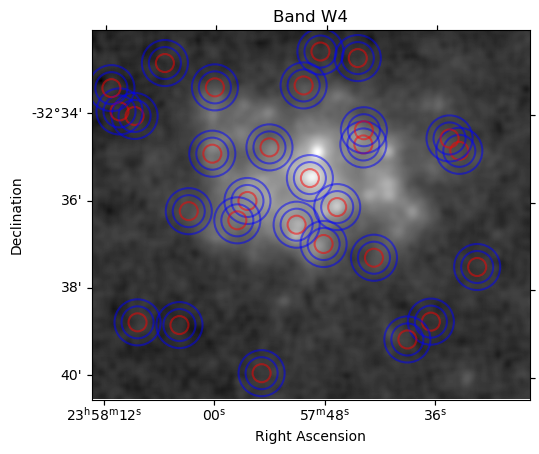

Band W3: 
[[485.0907  484.75238 484.52826 ... 485.9809  485.98273 485.88147]
 [484.93604 484.6136  484.41235 ... 486.12555 486.09204 485.9447 ]
 [484.8957  484.62512 484.4604  ... 486.20856 486.1316  485.938  ]
 ...
 [485.74524 485.80103 485.79236 ... 485.99976 486.05115 486.0188 ]
 [485.5739  485.68433 485.77783 ... 486.07874 486.0951  486.068  ]
 [485.46454 485.59125 485.72675 ... 485.9914  485.99    485.9729 ]]
[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [

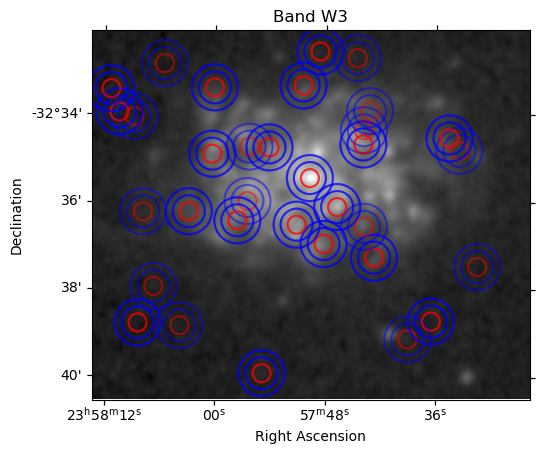

Band W2: 
[[7.7036934 7.694665  7.68083   ... 7.81129   7.825474  7.829296 ]
 [7.7232647 7.7141237 7.6985865 ... 7.837714  7.8442717 7.8367453]
 [7.7373724 7.7276525 7.712758  ... 7.8709164 7.870058  7.851307 ]
 ...
 [7.7651987 7.741791  7.73184   ... 7.8185844 7.821561  7.81901  ]
 [7.757022  7.7405186 7.7447157 ... 7.8122654 7.8208838 7.82738  ]
 [7.74228   7.730302  7.7498627 ... 7.8056183 7.8161173 7.8287354]]
[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [

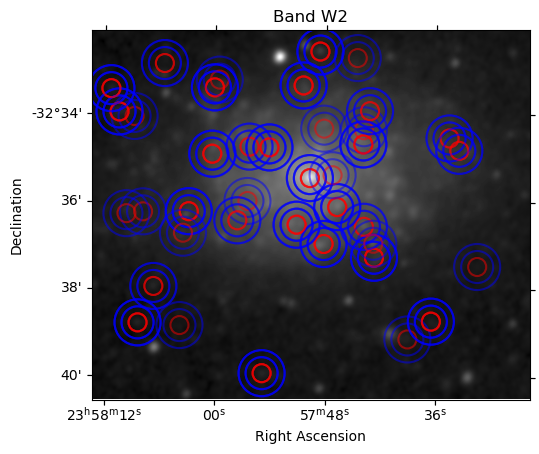

Band W1: 
[[2.7266917 2.746497  2.7605455 ... 2.8303592 2.8192692 2.8008873]
 [2.743185  2.770523  2.7873318 ... 2.825526  2.803267  2.7808976]
 [2.7550056 2.7865236 2.8037145 ... 2.8183782 2.7902033 2.767377 ]
 ...
 [2.68781   2.6723075 2.6680837 ... 2.7309496 2.7299297 2.7405295]
 [2.6866317 2.6829112 2.687535  ... 2.7390184 2.72869   2.7273357]
 [2.6841335 2.685159  2.6913772 ... 2.743722  2.7291133 2.7190766]]
[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [

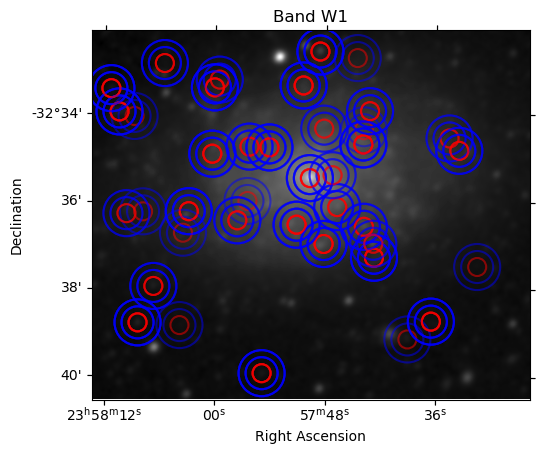

,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg,Target Counts,Target Flux,Annulus Counts,Annulus Flux,Image Data Shape,Mask Shape,Mask Type,Non-zero mask elements
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,Valid,37801.670626,2.031762,37801.670626,2.031763,127405.552796,6.847790,"(369, 437)","(369, 437)",bool,255.0
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,Valid,37854.108138,2.034519,37854.108138,2.034582,127578.439326,6.857083,"(369, 437)","(369, 437)",bool,240.0
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,Valid,37853.208001,2.034415,37853.208001,2.034533,127571.892822,6.856731,"(369, 437)","(369, 437)",bool,241.0
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,Valid,37792.988979,2.031039,37792.988979,2.031297,127360.193178,6.845352,"(369, 437)","(369, 437)",bool,251.0
5,{W4},6,281.147755,141.030790,9,16,23,0.000976,Valid,37870.171772,2.034469,37870.171772,2.035445,127575.285208,6.856913,"(369, 437)","(369, 437)",bool,219.0
8,{W4},9,270.537574,254.125605,9,16,23,0.002699,Valid,38112.836932,2.045789,38112.836932,2.048488,128285.138560,6.895066,"(369, 437)","(369, 437)",bool,226.0
10,{W4},11,244.422687,191.596758,9,16,23,0.012303,Valid,38367.279337,2.049861,38367.279337,2.062164,128540.477789,6.908790,"(369, 437)","(369, 437)",bool,256.0
12,{W4},13,230.855881,154.742167,9,16,23,0.004096,Valid,38068.727515,2.042021,38068.727515,2.046117,128048.873209,6.882367,"(369, 437)","(369, 437)",bool,255.0
13,{W4},14,227.715640,346.900800,9,16,23,0.035095,Valid,37798.069100,1.996474,37798.069100,2.031570,125192.781068,6.728858,"(369, 437)","(369, 437)",bool,256.0
21,{W4},22,168.969907,25.773980,9,16,23,0.000197,Valid,37804.453983,2.031716,37804.453983,2.031913,127402.640425,6.847634,"(369, 437)","(369, 437)",bool,250.0


,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg,Target Counts,Target Flux,Annulus Counts,Annulus Flux,Image Data Shape,Mask Shape,Mask Type,Non-zero mask elements
0,{W4},1,438.545629,85.376843,9,16,23,-0.223282,Low Flux,13481.764372,0.947899,13481.764372,0.724618,59439.853026,3.194772,"(369, 437)","(369, 437)",bool,92.0
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,Valid,37801.670626,2.031762,37801.670626,2.031763,127405.552796,6.847790,"(369, 437)","(369, 437)",bool,255.0
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,Valid,37854.108138,2.034519,37854.108138,2.034582,127578.439326,6.857083,"(369, 437)","(369, 437)",bool,240.0
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,Valid,37853.208001,2.034415,37853.208001,2.034533,127571.892822,6.856731,"(369, 437)","(369, 437)",bool,241.0
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,Valid,37792.988979,2.031039,37792.988979,2.031297,127360.193178,6.845352,"(369, 437)","(369, 437)",bool,251.0
5,{W4},6,281.147755,141.030790,9,16,23,0.000976,Valid,37870.171772,2.034469,37870.171772,2.035445,127575.285208,6.856913,"(369, 437)","(369, 437)",bool,219.0
6,{W4},7,277.237138,287.356364,9,16,23,-0.001256,Low Flux,37875.597249,2.036992,37875.597249,2.035737,127733.528561,6.865418,"(369, 437)","(369, 437)",bool,254.0
7,{W4},8,271.085639,171.908120,9,16,23,-0.001903,Low Flux,37914.416221,2.039726,37914.416221,2.037823,127904.952495,6.874632,"(369, 437)","(369, 437)",bool,253.0
8,{W4},9,270.537574,254.125605,9,16,23,0.002699,Valid,38112.836932,2.045789,38112.836932,2.048488,128285.138560,6.895066,"(369, 437)","(369, 437)",bool,226.0
9,{W4},10,246.942291,229.947587,9,16,23,-0.004947,Low Flux,38150.093693,2.055438,38150.093693,2.050490,128890.173990,6.927586,"(369, 437)","(369, 437)",bool,163.0


In [12]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
    
     ## Trying to plot the images now
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in rows:
            if row['Flag'] == 'Valid':
                target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
                annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        

display_data = pd.DataFrame(rows)
display_data




    









display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
pd.set_option("display.max_rows", None)

